In [2]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
data_path = 'gene_expression_er.csv'
df_er = pd.read_csv(data_path)
df_er

,DDR1,RFC2,HSPA6,PAX8,GUCA1A,UBE1L,THRA,PTPN21,CCL5,CYP2E1,...,ACTB.3,ACTB.4,GAPDH.3,GAPDH.4,GAPDH.5,STAT1.2,STAT1.3,STAT1.4,STAT1.5,er
0,10.780787,8.674201,7.738589,9.285511,6.610484,8.505162,6.867181,7.168175,6.252700,5.262454,...,14.318168,14.624740,14.986425,15.093565,15.074246,10.664389,7.241276,8.303160,8.246042,0
1,11.335393,9.354759,7.763657,9.025809,4.809869,8.674612,5.097706,5.654260,9.892701,3.438981,...,13.706087,14.203782,14.583225,14.544576,14.353156,12.419101,9.655342,10.845240,10.753146,1
2,11.028074,9.053889,6.327600,9.234409,4.621973,8.406754,6.932156,6.263502,8.777121,4.738016,...,14.101365,14.681984,14.736156,14.530003,14.258661,10.589271,7.033652,8.619232,8.433936,0
3,11.847736,9.139895,7.032598,9.656416,5.589404,9.106449,7.751138,6.371654,11.993179,5.185123,...,14.538633,14.896860,14.921864,15.014444,14.883588,12.781541,10.207268,11.450190,10.930990,1
4,12.359239,9.196708,7.873428,9.174188,5.325173,10.030778,7.156790,4.057771,6.359531,6.061211,...,14.456297,14.934535,14.352511,14.096428,13.948195,11.401921,6.894184,9.398871,8.556959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,10.785023,10.012078,6.855161,8.987488,5.833270,8.030344,5.473191,5.683147,10.456655,4.828817,...,13.924942,14.536470,15.532624,15.506850,15.360703,12.062116,7.645083,8.936828,9.183464,0
194,11.390198,9.830344,7.150656,8.766830,3.977743,8.014831,5.364158,6.170392,9.249901,5.571832,...,14.768498,15.089477,14.944650,15.012344,14.982389,11.601189,8.149682,9.752410,9.885926,0
195,10.735085,8.894038,7.262618,9.064142,3.781916,9.533836,7.063272,5.451382,8.613225,4.774023,...,13.709432,14.313515,14.481669,14.503332,14.231976,12.596178,9.442702,11.312659,10.895158,1
196,10.653104,8.854766,6.636791,9.283177,3.724769,9.722750,7.616948,4.402618,12.423745,5.884242,...,14.697298,15.053906,14.913014,14.911985,14.691579,12.389494,9.420274,10.884197,10.840915,1


In [41]:
x = df_er.drop(columns=['er'])
y = df_er['er']

# standardize the data for dimensionality reduction 
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

print(x.shape)
print(y.shape)
x.head()

(198, 16864)
(198,)


,DDR1,RFC2,HSPA6,PAX8,GUCA1A,UBE1L,THRA,PTPN21,CCL5,CYP2E1,...,ACTB.2,ACTB.3,ACTB.4,GAPDH.3,GAPDH.4,GAPDH.5,STAT1.2,STAT1.3,STAT1.4,STAT1.5
0,-0.800215,-0.156475,0.937822,0.051812,1.397760,-0.897219,0.241608,1.393678,-1.579403,-0.153397,...,0.032094,0.875754,0.366118,0.627650,1.261521,1.326446,-0.812892,0.107590,-0.732778,-0.588347
1,0.129836,1.047900,0.970138,-0.705788,-0.110988,-0.600414,-2.673770,0.208818,0.465775,-2.066165,...,-1.971908,-0.180865,-0.629085,-0.222085,0.292219,-0.012578,1.096455,1.827165,1.362022,1.456669
2,-0.385525,0.515454,-0.881125,-0.097262,-0.268428,-1.069589,0.348660,0.685639,-0.161027,-0.703517,...,0.902639,0.501493,0.501451,0.100213,0.266489,-0.188052,-0.894629,-0.040303,-0.472319,-0.435084
3,0.989012,0.667657,0.027708,1.133812,0.542190,0.155986,1.698010,0.770284,1.645954,-0.234515,...,0.179900,1.256337,1.009447,0.491589,1.121823,0.972405,1.490836,2.220310,1.860531,1.601734
4,1.846782,0.768198,1.111647,-0.272938,0.320789,1.775029,0.718766,-1.040669,-1.519378,0.684474,...,1.046594,1.114202,1.098515,-0.708310,-0.499037,-0.764570,-0.010363,-0.139648,0.170142,-0.334735


In [42]:
# https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [43]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3)

In [44]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.105 total time=   0.5s
[CV 2/5] END .................model__alpha=0.1;, score=-0.105 total time=   0.8s
[CV 3/5] END .................model__alpha=0.1;, score=-0.099 total time=   0.6s
[CV 4/5] END .................model__alpha=0.1;, score=-0.151 total time=   0.6s
[CV 5/5] END .................model__alpha=0.1;, score=-0.172 total time=   0.6s
[CV 1/5] END .................model__alpha=0.2;, score=-0.133 total time=   0.5s
[CV 2/5] END .................model__alpha=0.2;, score=-0.158 total time=   0.5s
[CV 3/5] END .................model__alpha=0.2;, score=-0.120 total time=   0.5s
[CV 4/5] END .................model__alpha=0.2;, score=-0.178 total time=   0.5s
[CV 5/5] END .................model__alpha=0.2;, score=-0.176 total time=   0.6s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.195 total time=   0.5s
[CV 2/5] END .model__alpha=0.30000000000000004;

[CV 2/5] END .................model__alpha=2.1;, score=-0.235 total time=   0.5s
[CV 3/5] END .................model__alpha=2.1;, score=-0.186 total time=   0.5s
[CV 4/5] END .................model__alpha=2.1;, score=-0.257 total time=   0.5s
[CV 5/5] END .................model__alpha=2.1;, score=-0.241 total time=   0.5s
[CV 1/5] END .................model__alpha=2.2;, score=-0.211 total time=   0.5s
[CV 2/5] END .................model__alpha=2.2;, score=-0.235 total time=   0.5s
[CV 3/5] END .................model__alpha=2.2;, score=-0.186 total time=   0.5s
[CV 4/5] END .................model__alpha=2.2;, score=-0.257 total time=   0.5s
[CV 5/5] END .................model__alpha=2.2;, score=-0.241 total time=   0.5s
[CV 1/5] END ..model__alpha=2.3000000000000003;, score=-0.211 total time=   0.5s
[CV 2/5] END ..model__alpha=2.3000000000000003;, score=-0.235 total time=   0.4s
[CV 3/5] END ..model__alpha=2.3000000000000003;, score=-0.186 total time=   0.5s
[CV 4/5] END ..model__alpha=

[CV 4/5] END .................model__alpha=4.1;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=4.1;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=4.2;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=4.2;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=4.2;, score=-0.186 total time=   0.5s
[CV 4/5] END .................model__alpha=4.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=4.2;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=4.3;, score=-0.211 total time=   0.5s
[CV 2/5] END .................model__alpha=4.3;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=4.3;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=4.3;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=4.3;, score=-0.241 total time=   0.4s
[CV 1/5] END ..model__alpha=

[CV 1/5] END .................model__alpha=6.2;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=6.2;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=6.2;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=6.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=6.2;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=6.3;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=6.3;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=6.3;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=6.3;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=6.3;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=6.4;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=6.4;, score=-0.235 total time=   0.4s
[CV 3/5] END ...............

[CV 3/5] END .................model__alpha=8.2;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=8.2;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=8.2;, score=-0.241 total time=   0.5s
[CV 1/5] END .................model__alpha=8.3;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=8.3;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=8.3;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=8.3;, score=-0.257 total time=   0.4s
[CV 5/5] END .................model__alpha=8.3;, score=-0.241 total time=   0.4s
[CV 1/5] END .................model__alpha=8.4;, score=-0.211 total time=   0.4s
[CV 2/5] END .................model__alpha=8.4;, score=-0.235 total time=   0.4s
[CV 3/5] END .................model__alpha=8.4;, score=-0.186 total time=   0.4s
[CV 4/5] END .................model__alpha=8.4;, score=-0.257 total time=   0.4s
[CV 5/5] END ...............

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [81]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [82]:
importance = np.abs(coefficients)
gene_selected = np.array(x.columns)[importance > 0]
print(len(gene_selected))
print(gene_selected)

26
['SKP1A' 'DHCR7.1' 'EPHB4' 'ADM' 'KIAA0040' 'C1orf123' 'RABEP1' 'BCL2'
 'BCL2.1' 'TTLL4' 'CXADR' 'MORC2' 'KYNU' 'CXCL1' 'DNALI1' 'ESR1' 'DACH1'
 'DACH1.1' 'PFDN5' 'COPS7A' 'GATA3.2' 'MPPE1.1' 'EIF4B.1' 'CYP21A2' 'EVL'
 'YEATS2']


In [83]:
annot = pd.read_csv('annot.csv')
index = annot['HUGO.gene.symbol'].isin(gene_selected)

df_gene_description = annot[index]
df_gene_description

df_gene_description = df_gene_description.drop_duplicates(subset=['HUGO.gene.symbol'], keep='first')
df_gene_description[['HUGO.gene.symbol','Description']]

,HUGO.gene.symbol,Description
238,SKP1A,S-phase kinase-associated protein 1A (p19A)
2421,EPHB4,EPH receptor B4
2440,ADM,adrenomedullin
2670,KIAA0040,KIAA0040
2724,C1orf123,chromosome 1 open reading frame 123
2750,RABEP1,"rabaptin, RAB GTPase binding effector protein 1"
3210,BCL2,B-cell CLL/lymphoma 2
3228,TTLL4,"tubulin tyrosine ligase-like family, member 4"
3443,CXADR,coxsackie virus and adenovirus receptor
3482,MORC2,MORC family CW-type zinc finger 2


In [84]:
gene_selected_er = np.append(gene_selected, 'er')
df_er[gene_selected_er].to_csv("df_gene_selected_lasso.csv", index=False)
df_er[gene_selected_er]

,SKP1A,DHCR7.1,EPHB4,ADM,KIAA0040,C1orf123,RABEP1,BCL2,BCL2.1,TTLL4,...,DACH1.1,PFDN5,COPS7A,GATA3.2,MPPE1.1,EIF4B.1,CYP21A2,EVL,YEATS2,er
0,10.950684,10.847817,10.348075,12.378857,8.531358,9.961502,6.466060,3.066486,7.299545,5.719637,...,1.873392,12.673839,9.859017,11.067215,9.316232,12.053945,5.583262,8.891237,9.314181,0
1,11.524726,8.545180,9.688557,7.871138,9.413448,9.702861,9.073238,5.834698,9.599270,5.660237,...,6.541081,13.143022,10.301422,14.023003,9.342100,11.385603,3.328785,9.855322,7.804451,1
2,10.631518,10.051138,10.336838,9.489243,8.160630,9.648145,5.754082,3.013021,8.612907,9.041833,...,6.246586,13.205859,9.082100,10.726372,8.485777,11.665887,4.092910,9.678461,9.639825,0
3,11.620446,9.130228,9.676061,7.846630,9.466745,9.585241,7.112622,3.854089,10.498765,7.474594,...,6.067307,13.499292,9.753622,14.014380,9.200917,11.732913,4.520787,9.294257,8.164054,1
4,11.301659,9.918252,10.499267,7.991108,9.242927,9.858129,6.830208,7.786191,11.300058,7.394776,...,9.611886,13.346616,9.980930,15.183723,9.654363,12.032796,6.770835,12.079231,8.850277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,11.479448,9.681617,9.988570,10.056912,9.703584,9.906498,5.102518,2.905019,9.019462,11.328169,...,3.042143,13.122232,10.587523,10.090670,8.396330,11.488482,4.326447,8.746099,8.960718,0
194,10.547530,8.559069,9.162243,12.572942,7.391198,9.121194,6.758604,3.432785,6.632900,10.078281,...,4.470583,12.889018,9.732480,9.857022,9.749674,11.596549,3.893544,8.614434,9.130276,0
195,11.964774,8.145164,9.042707,9.040548,10.662562,10.561966,7.061038,2.782885,10.043965,8.077957,...,9.224620,14.006624,9.774871,14.576147,9.610708,12.308718,6.424055,10.040405,8.581619,1
196,11.263020,7.436270,9.322442,9.042685,9.835025,10.303320,6.946609,6.633564,10.462202,6.011709,...,6.800443,13.875693,9.703215,14.005065,9.237907,12.522147,5.429858,11.906226,8.671051,1


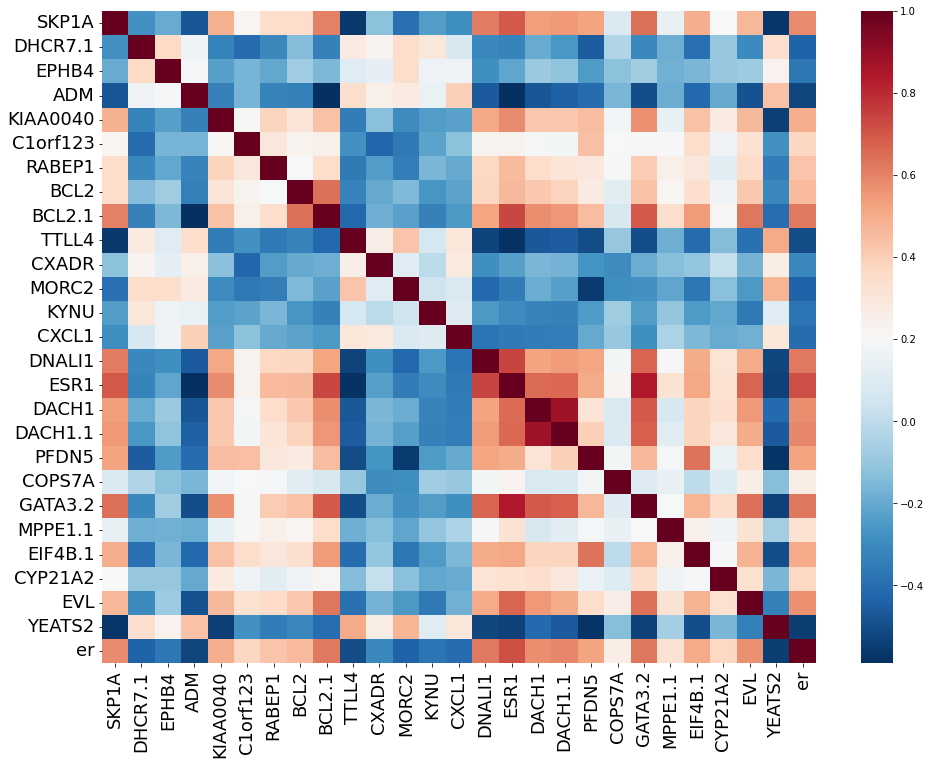

In [93]:
corr = df_er[gene_selected_er].corr()
plt.figure(figsize=(16, 12))

res = sns.heatmap(corr, 
            xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values, 
            annot_kws={"size": 80},
            cmap='RdBu_r')

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

plt.show()

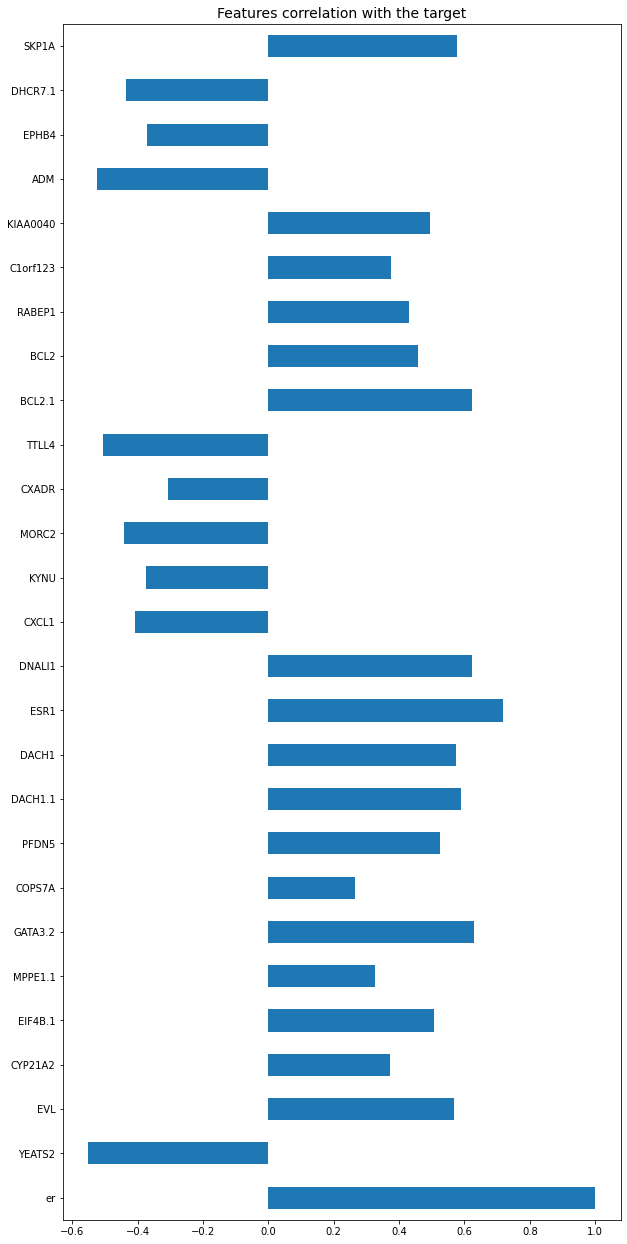

In [92]:
plt.figure(figsize=(10, 22))
plt.title('Features correlation with the target', fontsize=14)
corr['er'].plot(kind='barh')
plt.gca().invert_yaxis()